In [60]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import pytesseract
from pathlib import Path
import pandas as pd
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import clear_output

In [2]:
torch.cuda.is_available()

True

In [6]:
import kagglehub
#dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
dataset_path = kagglehub.dataset_download("chiragsaipanuganti/morph")

In [6]:
dataset_path

'/root/.cache/kagglehub/datasets/chiragsaipanuganti/morph/versions/2'

In [7]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_paths.append(os.path.join(root, file))

In [ ]:
def populate_whitecard(image_paths, naming, height=1540, width=1754, im_width=250, im_height=250, spacing=80):
    whitecard = np.ones((height, width, 3), dtype=np.uint8) * 255
    x = 10
    y = 10

    diagonal_size = int(np.sqrt(im_width**2 + im_height**2)) + 10

    for i, name in zip(image_paths, naming):
        img = cv2.imread(i)
        img = cv2.resize(img, (im_width, im_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rot_canvas = np.ones((diagonal_size, diagonal_size, 3), dtype=np.uint8) * 255
        start_x = (diagonal_size - im_width) // 2
        start_y = (diagonal_size - im_height) // 2
        rot_canvas[start_y:start_y + im_height, start_x:start_x + im_width] = img

        rot_angle = random.uniform(-180, 180)
        center = (diagonal_size // 2, diagonal_size // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
        rot_img = cv2.warpAffine(rot_canvas, rot_matrix, (diagonal_size, diagonal_size), borderValue=(255, 255, 255))

        whitecard[y:y+diagonal_size, x:x+diagonal_size] = rot_img

        cv2.putText(whitecard, str(name), (x + diagonal_size // 2, y + diagonal_size + (spacing // 2)), 
                   cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1.3, (0, 0, 0), 2, cv2.LINE_AA)

        x += diagonal_size + 40
        if x > (width-diagonal_size):
            x = 10
            y += diagonal_size + spacing
        if y > (height-diagonal_size):
            return whitecard
    return whitecard

def get_cards(image_paths, num, im_width, im_height):
    cards = []
    random.shuffle(image_paths)
    for i in range(num):
        card = populate_whitecard(image_paths[i*20:(i+1)*20], [f"{i*20+j+1}" for j in range(20)], im_height=im_height, im_width=im_width)
        cards.append(card)
    return cards

In [73]:
def populate_whitecard_labels_v2(image_paths, naming, height=1540, width=1754, im_width=250, im_height=250, spacing=80):
    whitecard = np.ones((height, width, 3), dtype=np.uint8) * 255
    x = 10
    y = 10

    diagonal_size = int(np.sqrt(im_width**2 + im_height**2)) + 10
    label_entries = []

    for i, name in zip(image_paths, naming):
        img = cv2.imread(i)
        img = cv2.resize(img, (im_width, im_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rot_canvas = np.ones((diagonal_size, diagonal_size, 3), dtype=np.uint8) * 255
        start_x = (diagonal_size - im_width) // 2
        start_y = (diagonal_size - im_height) // 2
        rot_canvas[start_y:start_y + im_height, start_x:start_x + im_width] = img

        rot_angle = random.uniform(-180, 180)
        center = (diagonal_size // 2, diagonal_size // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
        rot_img = cv2.warpAffine(rot_canvas, rot_matrix, (diagonal_size, diagonal_size), borderValue=(255, 255, 255))

        whitecard[y:y+diagonal_size, x:x+diagonal_size] = rot_img

        cv2.putText(whitecard, str(name), (x + diagonal_size // 2, y + diagonal_size + (spacing // 2)), 
                   cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1.3, (0, 0, 0), 2, cv2.LINE_AA)
        
        photo_x_center = (x + diagonal_size / 2) / width
        photo_y_center = (y + diagonal_size / 2) / height
        photo_width = diagonal_size / width
        photo_height = (diagonal_size + spacing) / height
        label_entries.append(f"0 {photo_x_center:.6f} {photo_y_center:.6f} {photo_width:.6f} {photo_height:.6f}")

        id_x_center = photo_x_center
        id_y_center = (y + diagonal_size + spacing / 2) / height
        id_width = photo_width
        id_height = spacing / height
        label_entries.append(f"1 {id_x_center:.6f} {id_y_center:.6f} {id_width:.6f} {id_height:.6f}")

        x += diagonal_size + 40
        if x > (width-diagonal_size):
            x = 10
            y += diagonal_size + spacing
        if y > (height-diagonal_size):
            break
    return whitecard, label_entries

def get_cards_labels(image_paths, num, im_width, im_height, output_path, starting_idx=0):
    images_path = Path("images") / Path(output_path)
    images_path.mkdir(parents=True, exist_ok=True)
    labels_path = Path("labels") / Path(output_path)
    labels_path.mkdir(parents=True, exist_ok=True)
    cards = []

    random.shuffle(image_paths)
    for i in range(starting_idx, starting_idx+num):
        imgs = image_paths[i*50:(i+1)*50]
        names = [f"{i*50+j+1}" for j in range(len(imgs))]
        card, labels = populate_whitecard_labels_v2(imgs, names, im_width=im_width, im_height=im_height)
        filename = f"card_{i+1}"
        
        card_bgr = cv2.cvtColor(card, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(images_path / f"{filename}.jpg"), card_bgr)

        with open(labels_path / f"{filename}.txt", "w") as f:
            f.write("\n".join(labels))
    return cards

In [74]:
for i in ['train_v2', 'valid_v2', 'test_v2']:
    get_cards_labels(image_paths, num=30, im_width=250, im_height=250, output_path=i, starting_idx=0)
    get_cards_labels(image_paths, num=30, im_width=200, im_height=200, output_path=i, starting_idx=30)
    get_cards_labels(image_paths, num=30, im_width=150, im_height=150, output_path=i, starting_idx=60)
    get_cards_labels(image_paths, num=15, im_width=175, im_height=175, output_path=i, starting_idx=90)
    get_cards_labels(image_paths, num=15, im_width=275, im_height=275, output_path=i, starting_idx=105)

In [11]:
model = YOLO('yolo11n.pt')  # nano
model = YOLO('yolo11s.pt')  # small
model = YOLO('yolo11m.pt')  # medium
model = YOLO('yolo11l.pt')  # large
model = YOLO('yolo11x.pt')  # extra large

In [12]:
model = YOLO('yolo11n-pose.pt')  # nano
model = YOLO('yolo11s-pose.pt')  # small
model = YOLO('yolo11m-pose.pt')  # medium
model = YOLO('yolo11l-pose.pt')  # large
model = YOLO('yolo11x-pose.pt')  # extra large

In [30]:
from ultralytics import YOLO

model = YOLO('yolo11x.pt')

model.train(
    data='person_entry.yaml',
    epochs=100,
    imgsz=1024,
    batch=8,
    name='person_entry_model'
)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.144 🚀 Python-3.11.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=person_entry.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_entry_model5, nbs=64, nms=False

train: Scanning /repos/uni-si/R2S4/DNN/End_project/labels/train... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1081.81it/s]

train: New cache created: /repos/uni-si/R2S4/DNN/End_project/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1304.3±1551.3 MB/s, size: 364.4 KB)


val: Scanning /repos/uni-si/R2S4/DNN/End_project/labels/valid... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 982.55it/s]

val: New cache created: /repos/uni-si/R2S4/DNN/End_project/labels/valid.cache


Plotting labels to runs/detect/person_entry_model5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/person_entry_model5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      36.7G      2.094      2.429      2.566        234       1024: 100%|██████████| 15/15 [06:19<00:00, 25.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:46<00:00, 13.37s/it]

                   all        120       2040      0.452       0.85      0.464       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      19.6G      1.013      1.243      1.427        245       1024: 100%|██████████| 15/15 [02:44<00:00, 10.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:15<00:00,  9.44s/it]

                   all        120       2040    0.00126     0.0221   0.000649   6.49e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      19.5G       1.07     0.8237      1.415        161       1024: 100%|██████████| 15/15 [02:26<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:00<00:00,  7.62s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      19.6G     0.9679     0.7604      1.355        235       1024: 100%|██████████| 15/15 [01:57<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      19.3G      0.884     0.6571      1.297        200       1024: 100%|██████████| 15/15 [01:50<00:00,  7.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      19.6G     0.8722     0.6347      1.334        187       1024: 100%|██████████| 15/15 [01:35<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:27<00:00,  3.42s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      19.6G     0.9144     0.8017      1.331        179       1024: 100%|██████████| 15/15 [02:03<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:39<00:00,  4.96s/it]

                   all        120       2040       0.03      0.529     0.0243     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      19.6G     0.8268     0.6917      1.248        267       1024: 100%|██████████| 15/15 [02:03<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:48<00:00,  6.00s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      19.6G     0.7426     0.6656      1.201        196       1024: 100%|██████████| 15/15 [01:56<00:00,  7.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:40<00:00,  5.03s/it]

                   all        120       2040    0.00699    0.00049     0.0035     0.0007



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      19.6G      0.866     0.5944      1.293        287       1024: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]

                   all        120       2040      0.165      0.289      0.128       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      19.6G      0.788     0.5502      1.211        206       1024: 100%|██████████| 15/15 [01:55<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]

                   all        120       2040          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      19.6G     0.7103      0.521      1.139        268       1024: 100%|██████████| 15/15 [01:53<00:00,  7.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:46<00:00,  5.82s/it]

                   all        120       2040      0.454      0.435       0.39      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      19.6G     0.6224     0.4431      1.089        262       1024: 100%|██████████| 15/15 [02:10<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.69s/it]

                   all        120       2040      0.992       0.98      0.994      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      19.4G     0.6062     0.4485      1.088        219       1024: 100%|██████████| 15/15 [01:49<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.17s/it]

                   all        120       2040      0.954      0.978       0.99      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      19.6G     0.5894     0.4149      1.074        234       1024: 100%|██████████| 15/15 [01:47<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:45<00:00,  5.70s/it]

                   all        120       2040      0.731      0.947      0.856      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      19.6G     0.5556     0.3863      1.057        146       1024: 100%|██████████| 15/15 [01:55<00:00,  7.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:48<00:00,  6.02s/it]

                   all        120       2040      0.949      0.958      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      19.6G     0.5337     0.3722      1.044        311       1024: 100%|██████████| 15/15 [01:52<00:00,  7.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:43<00:00,  5.48s/it]

                   all        120       2040      0.506      0.173      0.199       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      19.6G     0.4947     0.3524      1.015        221       1024: 100%|██████████| 15/15 [02:02<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:56<00:00,  7.05s/it]

                   all        120       2040      0.917       0.75      0.843      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      19.5G     0.5129     0.3606      1.009        286       1024: 100%|██████████| 15/15 [01:58<00:00,  7.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.63s/it]

                   all        120       2040      0.527       0.48      0.577      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      19.6G      0.504     0.3662      1.013        237       1024: 100%|██████████| 15/15 [01:41<00:00,  6.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]

                   all        120       2040      0.834      0.516      0.701      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      19.6G     0.4605     0.3352     0.9839        214       1024: 100%|██████████| 15/15 [01:36<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.55s/it]

                   all        120       2040       0.23      0.261      0.174     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      19.4G     0.4492     0.3282     0.9855        235       1024: 100%|██████████| 15/15 [02:04<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:47<00:00,  5.89s/it]

                   all        120       2040      0.871       0.68      0.819      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      19.5G     0.4062     0.3023     0.9408        199       1024: 100%|██████████| 15/15 [01:53<00:00,  7.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]

                   all        120       2040          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      19.6G     0.4076      0.303     0.9569        250       1024: 100%|██████████| 15/15 [01:41<00:00,  6.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:46<00:00,  5.79s/it]

                   all        120       2040          1          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      19.6G     0.3685     0.2768     0.9249        202       1024: 100%|██████████| 15/15 [01:50<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:40<00:00,  5.04s/it]

                   all        120       2040          1          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      19.6G     0.3791      0.283      0.956        238       1024: 100%|██████████| 15/15 [02:09<00:00,  8.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:47<00:00,  5.88s/it]

                   all        120       2040      0.287      0.305      0.235      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      19.6G     0.3471     0.2771     0.9344        182       1024: 100%|██████████| 15/15 [01:35<00:00,  6.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]

                   all        120       2040      0.164      0.134     0.0681     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      19.5G     0.3527     0.2686     0.9401        290       1024: 100%|██████████| 15/15 [01:37<00:00,  6.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:43<00:00,  5.40s/it]

                   all        120       2040      0.999      0.995      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      19.5G     0.3336     0.2539     0.9195        211       1024: 100%|██████████| 15/15 [01:41<00:00,  6.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.60s/it]

                   all        120       2040          1      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      19.4G     0.3493     0.2603     0.9268        225       1024: 100%|██████████| 15/15 [01:41<00:00,  6.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.57s/it]

                   all        120       2040          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      19.6G      0.352     0.2526     0.9049        313       1024: 100%|██████████| 15/15 [01:55<00:00,  7.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.36s/it]

                   all        120       2040          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      19.6G     0.3578      0.258     0.9262        182       1024: 100%|██████████| 15/15 [01:40<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.72s/it]

                   all        120       2040          1      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      19.6G     0.4004     0.2664     0.9503        213       1024: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:39<00:00,  4.95s/it]

                   all        120       2040          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      19.6G     0.3727     0.2572     0.9234        206       1024: 100%|██████████| 15/15 [01:55<00:00,  7.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]

                   all        120       2040          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      19.5G     0.3568     0.2507     0.9418        206       1024: 100%|██████████| 15/15 [01:46<00:00,  7.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:34<00:00,  4.26s/it]

                   all        120       2040      0.996      0.993      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      19.6G     0.3282     0.2371     0.8966        301       1024: 100%|██████████| 15/15 [01:48<00:00,  7.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:46<00:00,  5.84s/it]

                   all        120       2040      0.876      0.589      0.743      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      19.6G     0.3276     0.2401     0.9221        167       1024: 100%|██████████| 15/15 [01:47<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:34<00:00,  4.33s/it]

                   all        120       2040       0.29      0.404      0.358      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      19.4G     0.3153     0.2368     0.8996        247       1024: 100%|██████████| 15/15 [02:05<00:00,  8.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.12s/it]

                   all        120       2040      0.295      0.147      0.198     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      19.6G     0.3064     0.2288     0.8972        257       1024: 100%|██████████| 15/15 [02:00<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]

                   all        120       2040      0.166     0.0789     0.0921     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      19.6G     0.3146     0.2356     0.9067        180       1024: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:44<00:00,  5.59s/it]

                   all        120       2040          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      19.6G      0.291     0.2229     0.8952        164       1024: 100%|██████████| 15/15 [01:55<00:00,  7.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:36<00:00,  4.52s/it]

                   all        120       2040          1          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      19.5G     0.2918     0.2222     0.8858        216       1024: 100%|██████████| 15/15 [01:31<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.16s/it]

                   all        120       2040          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      19.6G      0.279     0.2198     0.8914        182       1024: 100%|██████████| 15/15 [01:53<00:00,  7.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:38<00:00,  4.86s/it]

                   all        120       2040          1          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      19.5G     0.2894     0.2226     0.9003        175       1024: 100%|██████████| 15/15 [01:47<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]

                   all        120       2040          1      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      19.5G     0.3042     0.2295     0.9028        218       1024: 100%|██████████| 15/15 [01:43<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.66s/it]

                   all        120       2040          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      19.3G     0.2765     0.2155     0.8932        242       1024: 100%|██████████| 15/15 [01:47<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.10s/it]

                   all        120       2040          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      19.7G     0.2952     0.2234        0.9        184       1024: 100%|██████████| 15/15 [01:35<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      19.5G     0.3097     0.2352     0.9078        168       1024: 100%|██████████| 15/15 [02:03<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]

                   all        120       2040          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      19.6G      0.298     0.2208     0.8729        207       1024: 100%|██████████| 15/15 [01:44<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]

                   all        120       2040          1          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      19.6G     0.2836     0.2096      0.877        209       1024: 100%|██████████| 15/15 [01:48<00:00,  7.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]

                   all        120       2040          1          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      19.5G     0.2662     0.2061       0.88        179       1024: 100%|██████████| 15/15 [01:55<00:00,  7.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:41<00:00,  5.23s/it]

                   all        120       2040          1          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      19.5G     0.2633      0.201     0.8769        254       1024: 100%|██████████| 15/15 [01:55<00:00,  7.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.18s/it]

                   all        120       2040          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      19.5G     0.2828     0.2104     0.8785        159       1024: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.15s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      19.4G     0.2511     0.1954     0.8555        219       1024: 100%|██████████| 15/15 [01:50<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      19.5G      0.249     0.1942     0.8598        139       1024: 100%|██████████| 15/15 [01:36<00:00,  6.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]

                   all        120       2040          1          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      19.6G     0.2561      0.196     0.8668        243       1024: 100%|██████████| 15/15 [01:53<00:00,  7.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]

                   all        120       2040          1          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      19.5G     0.2459     0.1935     0.8753        224       1024: 100%|██████████| 15/15 [02:01<00:00,  8.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:36<00:00,  4.51s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      19.6G     0.2512     0.1882     0.8732        201       1024: 100%|██████████| 15/15 [01:55<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      19.5G     0.2523     0.1926      0.872        207       1024: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:44<00:00,  5.51s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      19.6G     0.2386      0.184      0.873        170       1024: 100%|██████████| 15/15 [01:57<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.74s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      19.6G     0.2438      0.189     0.8632        177       1024: 100%|██████████| 15/15 [01:44<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.21s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      19.4G     0.2419     0.1824     0.8519        265       1024: 100%|██████████| 15/15 [01:51<00:00,  7.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.24s/it]

                   all        120       2040          1      0.996      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      19.5G     0.2241     0.1809     0.8562        254       1024: 100%|██████████| 15/15 [02:08<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.27s/it]

                   all        120       2040      0.985       0.69      0.905      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      19.6G     0.2128      0.174      0.853        204       1024: 100%|██████████| 15/15 [02:12<00:00,  8.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:51<00:00,  6.39s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      19.6G     0.2301     0.1839     0.8523        166       1024: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.27s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      19.6G     0.2242       0.18     0.8544        263       1024: 100%|██████████| 15/15 [02:01<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.73s/it]

                   all        120       2040      0.978      0.878      0.974      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      19.5G     0.2188     0.1759     0.8464        216       1024: 100%|██████████| 15/15 [01:50<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:38<00:00,  4.77s/it]

                   all        120       2040      0.874      0.462      0.695      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      19.6G     0.2052     0.1772     0.8646        216       1024: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:47<00:00,  5.96s/it]

                   all        120       2040      0.883      0.857      0.948       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      19.5G     0.2069     0.1754      0.841        230       1024: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:40<00:00,  5.01s/it]

                   all        120       2040          1          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      19.3G     0.1948     0.1696     0.8331        156       1024: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.56s/it]

                   all        120       2040          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      19.6G     0.1961     0.1671     0.8476        172       1024: 100%|██████████| 15/15 [01:42<00:00,  6.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:33<00:00,  4.13s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      19.5G     0.1963     0.1687     0.8423        202       1024: 100%|██████████| 15/15 [02:05<00:00,  8.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:38<00:00,  4.87s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      19.5G     0.1816     0.1595     0.8458        243       1024: 100%|██████████| 15/15 [01:55<00:00,  7.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.72s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      19.5G     0.1836      0.155     0.8332        193       1024: 100%|██████████| 15/15 [02:00<00:00,  8.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.30s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      19.5G     0.1751     0.1517     0.8447        288       1024: 100%|██████████| 15/15 [03:08<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      19.6G     0.1981     0.1656     0.8391        278       1024: 100%|██████████| 15/15 [01:22<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      19.5G     0.1974      0.164     0.8536        291       1024: 100%|██████████| 15/15 [00:58<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.64s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      19.4G     0.1917      0.161     0.8462        248       1024: 100%|██████████| 15/15 [01:17<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      19.6G     0.1803     0.1555     0.8533        212       1024: 100%|██████████| 15/15 [01:21<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      19.7G     0.1838     0.1608      0.851        259       1024: 100%|██████████| 15/15 [01:22<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      19.6G     0.1784     0.1506     0.8396        245       1024: 100%|██████████| 15/15 [00:57<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      19.6G     0.1682     0.1487     0.8354        184       1024: 100%|██████████| 15/15 [01:29<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:19<00:00,  2.48s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      19.5G     0.1568     0.1395     0.8266        219       1024: 100%|██████████| 15/15 [01:15<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      19.6G     0.1643     0.1418     0.8294        242       1024: 100%|██████████| 15/15 [01:23<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      19.6G     0.1567     0.1404     0.8264        197       1024: 100%|██████████| 15/15 [01:15<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:21<00:00,  2.73s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      19.4G     0.1522     0.1393     0.8357        262       1024: 100%|██████████| 15/15 [01:16<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:19<00:00,  2.39s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      19.5G     0.1556     0.1341      0.817        258       1024: 100%|██████████| 15/15 [01:04<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:27<00:00,  3.48s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      19.5G     0.1642     0.1401     0.8277        189       1024: 100%|██████████| 15/15 [01:30<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:18<00:00,  2.34s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      19.6G     0.1619     0.1447     0.8424        252       1024: 100%|██████████| 15/15 [01:15<00:00,  5.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      19.6G     0.1494     0.1345     0.8262        372       1024: 100%|██████████| 15/15 [01:16<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

                   all        120       2040          1          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      19.6G     0.1163     0.1148     0.7975        156       1024: 100%|██████████| 15/15 [01:12<00:00,  4.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:21<00:00,  2.66s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      19.6G     0.1213     0.1154     0.7947        152       1024: 100%|██████████| 15/15 [01:08<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:22<00:00,  2.83s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      19.6G     0.1224     0.1151     0.7897        116       1024: 100%|██████████| 15/15 [01:08<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:23<00:00,  2.90s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      19.4G     0.1103     0.1066     0.8071        138       1024: 100%|██████████| 15/15 [01:19<00:00,  5.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      19.6G     0.1098     0.1075     0.7972        136       1024: 100%|██████████| 15/15 [01:13<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      19.6G     0.1099      0.108     0.8074        144       1024: 100%|██████████| 15/15 [01:09<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      19.6G     0.1159     0.1143     0.8027        133       1024: 100%|██████████| 15/15 [01:26<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.55s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      19.6G     0.1121     0.1125     0.8073        135       1024: 100%|██████████| 15/15 [01:21<00:00,  5.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:20<00:00,  2.59s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      19.6G     0.1073     0.1068     0.7981        150       1024: 100%|██████████| 15/15 [01:13<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:19<00:00,  2.48s/it]

                   all        120       2040          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      19.6G    0.09833     0.1008      0.806        132       1024: 100%|██████████| 15/15 [01:14<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:34<00:00,  4.26s/it]

                   all        120       2040          1          1      0.995      0.995



100 epochs completed in 3.998 hours.
Optimizer stripped from runs/detect/person_entry_model5/weights/last.pt, 114.5MB
Optimizer stripped from runs/detect/person_entry_model5/weights/best.pt, 114.5MB

Validating runs/detect/person_entry_model5/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


                   all        120       2040          1          1      0.995      0.995
Speed: 0.7ms preprocess, 68.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/person_entry_model5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x76980db69450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [32]:
from ultralytics import YOLO

# Załaduj wytrenowany model
model = YOLO('runs/detect/person_entry_model5/weights/best.pt')

# Uruchom inferencję na folderze testowym
results = model.predict(
    source='images/test',
    save=True,
    conf=0.25,
    imgsz=1024
)


image 1/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_1.jpg: 928x1024 12 person_entrys, 26.5ms
image 2/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_10.jpg: 928x1024 12 person_entrys, 25.3ms
image 3/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_100.jpg: 928x1024 12 person_entrys, 25.5ms
image 4/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_101.jpg: 928x1024 12 person_entrys, 25.3ms
image 5/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_102.jpg: 928x1024 12 person_entrys, 25.0ms
image 6/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_103.jpg: 928x1024 12 person_entrys, 23.8ms
image 7/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_104.jpg: 928x1024 12 person_entrys, 24.2ms
image 8/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_105.jpg: 928x1024 12 person_entrys, 23.5ms
image 9/120 /repos/uni-si/R2S4/DNN/End_project/images/test/card_106.jpg: 928x1024 12 person_entrys, 24.4ms
image 10/120 /repos/uni-si/R2S4/DNN/End

In [ ]:
def prepare_yolo2_training_data(cards_path, yolo1_results, output_img_dir, output_lbl_dir):
    cards_dir = Path(cards_path)
    Path(output_img_dir).mkdir(parents=True, exist_ok=True)
    Path(output_lbl_dir).mkdir(parents=True, exist_ok=True)

    # Mapowanie nazwy pliku na pełną ścieżkę
    card_paths = {p.name: p for p in cards_dir.glob("*.jpg")}

    for result in yolo1_results:
        img_path = Path(result.path)
        img_name = img_path.name

        if img_name not in card_paths:
            print(f"Warning: {img_name} not found in cards_dir.")
            continue

        # Wyciągnięcie ID karty z nazwy pliku
        img_id = int(img_name.split("_")[1].split(".")[0])

        # Dobranie odpowiedniego ratio na podstawie img_id
        if img_id <= 30:
            photo_height_ratio = 0.82
        elif img_id <= 60:
            photo_height_ratio = 0.80
        elif img_id <= 90:
            photo_height_ratio = 0.75
        elif img_id <= 105:
            photo_height_ratio = 0.77
        else:
            photo_height_ratio = 0.842

        id_height_ratio = 1.0 - photo_height_ratio

        img = cv2.imread(str(card_paths[img_name]))
        h, w = img.shape[:2]

        boxes = result.boxes.xywhn.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy().astype(int)

        for idx, (box, cls) in enumerate(zip(boxes, classes)):
            x_c, y_c, bw, bh = box

            # Przeliczenie boxa YOLO na piksele
            x_min = int((x_c - bw / 2) * w)
            x_max = int((x_c + bw / 2) * w)
            y_min = int((y_c - bh / 2) * h)
            y_max = int((y_c + bh / 2) * h)

            # Wycinamy crop z oryginalnego obrazu
            crop = img[y_min:y_max, x_min:x_max]

            # Zapis cropa do output_img_dir
            crop_filename = f"{img_name[:-4]}_entry_{idx}.jpg"
            cv2.imwrite(str(Path(output_img_dir) / crop_filename), crop)

            # Tworzymy label dla drugiego modelu
            labels = []

            # Box dla zdjęcia (klasa 0)
            px_c = 0.5
            py_c = photo_height_ratio / 2
            pw = 1.0
            ph = photo_height_ratio
            labels.append(f"0 {px_c:.6f} {py_c:.6f} {pw:.6f} {ph:.6f}")

            # Box dla ID (klasa 1)
            ix_c = 0.5
            iy_c = photo_height_ratio + id_height_ratio / 2
            iw = 1.0
            ih = id_height_ratio
            labels.append(f"1 {ix_c:.6f} {iy_c:.6f} {iw:.6f} {ih:.6f}")

            label_filename = f"{img_name[:-4]}_entry_{idx}.txt"
            with open(Path(output_lbl_dir) / label_filename, "w") as f:
                f.write("\n".join(labels))


In [75]:
from ultralytics import YOLO
model = YOLO('runs/detect/person_entry_model5/weights/best.pt')

for i in ['train_v2', 'valid_v2', 'test_v2']:
    results = model.predict(
        source=f'images/{i}',
        save=False,
        conf=0.25,
        imgsz=1024
    )

    prepare_yolo2_training_data(f'images/{i}', results, output_img_dir=f'images/{i}_yolo2', output_lbl_dir=f'labels/{i}_yolo2')


image 1/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_1.jpg: 928x1024 12 person_entrys, 25.2ms
image 2/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_10.jpg: 928x1024 12 person_entrys, 37.7ms
image 3/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_100.jpg: 928x1024 24 person_entrys, 25.5ms
image 4/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_101.jpg: 928x1024 24 person_entrys, 24.7ms
image 5/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_102.jpg: 928x1024 24 person_entrys, 24.7ms
image 6/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_103.jpg: 928x1024 24 person_entrys, 25.4ms
image 7/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_104.jpg: 928x1024 24 person_entrys, 24.6ms
image 8/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_105.jpg: 928x1024 24 person_entrys, 24.6ms
image 9/120 /repos/uni-si/R2S4/DNN/End_project/images/train_v2/card_106.jpg: 928x1024 12 person_entrys, 23.7ms
ima

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11x.pt')

model.train(
    data='split_image_id.yaml',
    epochs=100,
    imgsz=1024,
    batch=8,
    name='split_image_id_model'
)

In [64]:
class CardProcessor:
    def __init__(self, detection_model="yolo11x.pt", pose_model="yolo11x-pose.pt"):
        self.detection_model = YOLO(detection_model)
        self.pose_model = YOLO(pose_model)

        self.debug_ocr_path = Path("debug_ocr_images")
        self.debug_ocr_path.mkdir(exist_ok=True)
        self.ocr_debug_counter = 0

        try:
            self.trocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-stage1', use_fast=True)
            self.trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-stage1')
            if torch.cuda.is_available() and self.trocr_model is not None:
                self.trocr_model.to('cuda')
            print("TrOCR model loaded successfully.")
        except Exception as e:
            print(f"Error loading TrOCR model: {e}. TrOCR will not be available.")
            self.trocr_processor = None
            self.trocr_model = None
    
    def process_card(self, card_path):
        card = cv2.imread(card_path)

        image_regions = self.detect_image_regions(card)

        print(f"Found {len(image_regions)} image regions.")

        results = []
        valid_count = 0
        for i, region in enumerate(image_regions):
            crop = self.extract_crop(card, region)
            if crop.shape[0] < 50 or crop.shape[1] < 50:
                continue
        
            rotated_crop, angle = self.correct_orientation(crop)
        
            is_valid = self.validate_photo(rotated_crop)

            if is_valid:
                valid_count += 1
                id = self.find_id(card, region)

                results.append({
                    'id': id,
                    'rotated_crop': rotated_crop,
                    'angle': angle,
                    'source_card': Path(card_path).name,
                    'region_idx': i,
                    'region': region
                })
        print(f"Valid faces found: {valid_count}/{len(image_regions)}")
        return results
    
    def detect_image_regions(self, card):
        # This method will now primarily use YOLO to detect image content.
        # Padding will be added to YOLO detections to make them less tightly cropped.
        
        yolo_detected_content_regions = []
        yolo_results = self.detection_model(card, classes=[0], verbose=False) # classes=[0] for person/face
        
        # Define padding percentage (e.g., 15% added to each side, so total increase is 30% of original)
        # Or, simpler: increase width and height by a factor. Let's try increasing w and h by 20%.
        padding_factor_w = 1.20 # Increase width by 20%
        padding_factor_h = 1.20 # Increase height by 20%

        card_h_for_bounds, card_w_for_bounds = card.shape[:2]

        for result in yolo_results:
            if result.boxes is not None:
                for box in result.boxes:
                    if box.conf[0] > 0.3: 
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        
                        orig_x, orig_y = int(x1), int(y1)
                        orig_w, orig_h = int(x2 - x1), int(y2 - y1)

                        if orig_w <= 0 or orig_h <= 0: # Skip invalid original detections
                            continue

                        # Calculate new dimensions with padding
                        padded_w = int(orig_w * padding_factor_w)
                        padded_h = int(orig_h * padding_factor_h)

                        # Calculate new top-left coordinates, keeping the center
                        # delta_w = padded_w - orig_w
                        # delta_h = padded_h - orig_h
                        # new_x = orig_x - delta_w // 2
                        # new_y = orig_y - delta_h // 2
                        
                        # Simpler: calculate center, then new x1,y1 from new w,h
                        center_x = orig_x + orig_w / 2
                        center_y = orig_y + orig_h / 2

                        new_x = int(round(center_x - padded_w / 2))
                        new_y = int(round(center_y - padded_h / 2))
                        
                        # Ensure padded region is within card boundaries
                        final_x = max(0, new_x)
                        final_y = max(0, new_y)
                        final_w = min(padded_w, card_w_for_bounds - final_x)
                        final_h = min(padded_h, card_h_for_bounds - final_y)

                        if final_w > 0 and final_h > 0: 
                            yolo_detected_content_regions.append((final_x, final_y, final_w, final_h))
                            
        print(f"YOLO detected and padded {len(yolo_detected_content_regions)} raw content regions.")

        # Deduplicate regions detected by YOLO
        unique_yolo_regions = self.remove_duplicate_regions(yolo_detected_content_regions, iou_threshold=0.4) 
        print(f"Unique content regions after YOLO deduplication: {len(unique_yolo_regions)}")
        
        # Filter these content regions using your existing filter_valid_regions method
        # The filter_valid_regions parameters (min_expected_content_dimension = 180, 
        # max_expected_content_dimension = 330) should be appropriate for these padded regions.
        # Original content ~200-283. Padded by 1.2 factor -> ~240-340. This range is mostly
        # covered by [180,330], though the upper bound might clip some slightly.
        # If issues persist, max_expected_content_dimension might need a slight increase.
        valid_content_regions = self.filter_valid_regions(unique_yolo_regions, card.shape)
        print(f"Valid content regions after filtering: {len(valid_content_regions)}")

        final_regions_sorted = sorted(valid_content_regions, key=lambda r: (r[1], r[0]))
        
        return final_regions_sorted
    
    def remove_duplicate_regions(self, regions, iou_threshold=0.4):
        if not regions:
            return []
        
        regions_list = list(regions)
        unique_regions = []

        while regions_list:
            current_region = regions_list.pop(0) 
            unique_regions.append(current_region)

            remaining_regions_after_check = []
            for region_to_compare in regions_list:
                iou = self.calculate_iou(current_region, region_to_compare)
                if iou <= iou_threshold: 
                    remaining_regions_after_check.append(region_to_compare)

            regions_list = remaining_regions_after_check 
            
        return unique_regions
    
    def calculate_iou(self, region1, region2):
        x1, y1, w1, h1 = region1
        x2, y2, w2, h2 = region2

        x_intersect = max(x1, x2)
        y_intersect = max(y1, y2)
        w_intersect = min(x1 + w1, x2 + w2)
        h_intersect = min(y1 + h1, y2 + h2)

        if w_intersect <= x_intersect or h_intersect <= y_intersect:
            return 0
        
        intersection = (w_intersect - x_intersect) * (h_intersect - y_intersect)

        area1 = w1 * h1
        area2 = w2 * h2

        if area1 == 0 or area2 == 0:
            return 0
        
        iou = intersection / float(area1 + area2 - intersection)

        return iou
    
    def filter_valid_regions(self, regions, card_shape):
        valid_regions = []
        card_h, card_w = card_shape[:2]
        min_size = 100
        max_size = min(card_h, card_w) // 3

        for x, y, w, h in regions:
            aspect_ratio = max(w, h) / min(w, h) if min(w,h) > 0 else 0 
            if aspect_ratio > 1.5:
                continue
            if min_size <= min(w, h) and max(w, h) <= max_size:
                margin = 5
                if (margin < x < card_w - w - margin and
                    margin < y < card_h - h - margin):
                    valid_regions.append((x, y, w, h))

        return valid_regions
    
    def find_id(self, card, region):
        x, y, w, h = region

        search_areas = []

        below_y = y + h
        below_h = min(80, card.shape[0] - below_y)
        search_x = max(0, x + 10)
        search_w = min(card.shape[1] - search_x, w + 40)

        if below_y + below_h <= card.shape[0] and search_x + search_w <= card.shape[1] and below_h > 0 and search_w > 0:
            search_areas.append(('below', (search_x, below_y, search_w, below_h)))
        
        #above_h = min(60, y)
        #if above_h > 10:
        #    search_areas.append(('above', (x, max(0, y - above_h), w, above_h)))

        #right_x = x + w + 2
        #right_w = min(100, card.shape[1] - right_x)
        #if right_x + right_w <= card.shape[1]:
        #    search_areas.append(('right', (right_x, y, right_w, h)))
        
        #left_w = min(100, x)
        #if left_w > 10:
        #    search_areas.append(('left', (max(0, x - left_w), y, left_w, h)))

        for location, (sx, sy, sw, sh) in search_areas:
            id = self.extract_id(card, (sx, sy, sw, sh))

            if id not in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                return id
            
        return "ID_NOT_DETECTED"
    
    def extract_id(self, card, region):
        if self.trocr_model is None or self.trocr_processor is None:
            print("Debug - TrOCR model not initialized, skipping OCR.")
            return "OCR_ERROR"
        
        x, y, w, h = region

        x = max(0, x)
        y = max(0, y)
        w = min(w, card.shape[1] - x)
        h = min(h, card.shape[0] - y)

        if w <= 0 or h <= 0:
            print(f"Debug - Invalid crop dimensions for OCR: w={w}, h={h}")
            return "ID_NOT_FOUND"
        
        id_crop = card[y:y+h, x:x+w]

        if id_crop.size == 0:
            print(f"Debug - Empty crop for OCR for region {region}")
            return "ID_NOT_FOUND"
        
        min_crop_dim_for_ocr = 10
        if id_crop.shape[0] < min_crop_dim_for_ocr or id_crop.shape[1] < min_crop_dim_for_ocr:
            print(f"Debug - OCR crop too small: {id_crop.shape}")
            return "ID_NOT_DETECTED"
        
        ocr_attempt_filename_prefix = f"ocr_input_{self.ocr_debug_counter}"
        self.ocr_debug_counter += 1

        try:
            pil_image = Image.fromarray(cv2.cvtColor(id_crop, cv2.COLOR_BGR2RGB))
            
            pixel_values = self.trocr_processor(images=pil_image, return_tensors="pt").pixel_values
            if torch.cuda.is_available():
                 pixel_values = pixel_values.to(self.trocr_model.device)

            generated_ids = self.trocr_model.generate(pixel_values, max_length=10) 

            decoded_texts = self.trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)

            if not decoded_texts or not decoded_texts[0].strip():
                debug_filename = self.debug_ocr_path / f"{ocr_attempt_filename_prefix}_fails_empty.png"
                cv2.imwrite(str(debug_filename), id_crop)
                print(f"Debug - Saved empty/whitespace OCR crop to {debug_filename}")
                return "ID_NOT_DETECTED"

            id_text_from_ocr = decoded_texts[0].strip()

            numeric_id_text = "".join(filter(str.isdigit, id_text_from_ocr))

            if not numeric_id_text:
                debug_filename = self.debug_ocr_path / f"{ocr_attempt_filename_prefix}_fails_nonumeric_{id_text_from_ocr.replace(' ','_')}.png"
                cv2.imwrite(str(debug_filename), id_crop)
                print(f"Debug - Saved non-numeric OCR crop to {debug_filename} (Raw: '{id_text_from_ocr}')")
                return "ID_NOT_DETECTED"
            
            print(f"Debug - TrOCR extracted ID: {numeric_id_text} from region {region}")
            return numeric_id_text

        except Exception as e:
            print(f"Debug - Exception during TrOCR processing in extract_id for region {region}: {e}")
            return "OCR_ERROR"
        
    def correct_orientation(self, crop):
        best_crop = crop.copy()
        best_angle = 0
        best_score = 0

        angles = list(range(0, 360, 15))

        for angle in angles:
            if angle == 0:
                rotated = crop
            else:
                rotated = self.rotate_image(crop, angle)

            orientation_data = self.analyze_face_orientation(rotated)

            if orientation_data['has_face']:
                score = self.calculate_orientation_score(orientation_data)
                if score > best_score:
                    best_score = score
                    best_crop = rotated.copy()
                    best_angle = angle

        if best_angle > 0:
            angles = list(range(max(0, best_angle - 10), min(360, best_angle + 11), 1))

            for angle in angles:
                rotated = self.rotate_image(crop, angle)
                orientation_data = self.analyze_face_orientation(rotated)

                if orientation_data['has_face']:
                    score = self.calculate_orientation_score(orientation_data)
                    if score > best_score:
                        best_score = score
                        best_crop = rotated.copy()
                        best_angle = angle

        return best_crop, best_angle

    def analyze_face_orientation(self, image):

        try:
            results = self.pose_model(image, verbose=False)

            orientation_data = {
                'has_face': False,
                'confidence': 0,
                'face_upright': False,
                'keypoints': {},
            }

            for result in results:
                keypoints = result.keypoints
                boxes = result.boxes

                if keypoints is not None and boxes is not None and len(boxes) > 0:
                    if boxes.conf.is_cuda:
                        best_idx = torch.argmax(boxes.conf).item()
                    else:
                        best_idx = np.argmax(boxes.conf.cpu().numpy()).item()

                    kp = keypoints[best_idx].cpu()
                    box_conf = boxes.conf[best_idx].cpu().item()

                    nose_tensor = kp.xy[0][0]
                    left_eye_tensor = kp.xy[0][1]
                    right_eye_tensor = kp.xy[0][2]

                    nose = nose_tensor.tolist() if torch.is_tensor(nose_tensor) and nose_tensor.numel() == 2 else [0,0]
                    left_eye = left_eye_tensor.tolist() if torch.is_tensor(left_eye_tensor) and left_eye_tensor.numel() == 2 else [0,0]
                    right_eye = right_eye_tensor.tolist() if torch.is_tensor(right_eye_tensor) and right_eye_tensor.numel() == 2 else [0,0]

                    valid_keypoints = 0
                    if nose[0] > 0 and nose[1] > 0:
                        orientation_data['keypoints']['nose'] = nose
                        valid_keypoints += 1

                    if left_eye[0] > 0 and left_eye[1] > 0:
                        orientation_data['keypoints']['left_eye'] = left_eye
                        valid_keypoints += 1

                    if right_eye[0] > 0 and right_eye[1] > 0:
                        orientation_data['keypoints']['right_eye'] = right_eye
                        valid_keypoints +=1

                    if valid_keypoints >= 2:
                        orientation_data['has_face'] = True
                        orientation_data['confidence'] = box_conf

                        if 'nose' in orientation_data['keypoints'] and ('left_eye' in orientation_data['keypoints'] or 'right_eye' in orientation_data['keypoints']):
                            nose_y = orientation_data['keypoints']['nose'][1]
                            
                            if 'left_eye' in orientation_data['keypoints'] and 'right_eye' in orientation_data['keypoints']:
                                avg_eye_y = (orientation_data['keypoints']['left_eye'][1] + orientation_data['keypoints']['right_eye'][1]) / 2
                                orientation_data['face_upright'] = avg_eye_y < nose_y
                            elif 'left_eye' in orientation_data['keypoints']:
                                orientation_data['face_upright'] = orientation_data['keypoints']['left_eye'][1] < nose_y
                            elif 'right_eye' in orientation_data['keypoints']:
                                orientation_data['face_upright'] = orientation_data['keypoints']['right_eye'][1] < nose_y
                            else:
                                orientation_data['face_upright'] = False
                        else:
                            orientation_data['face_upright'] = False
                        break
            return orientation_data
        
        except Exception as e:
            return {'has_face': False, 'confidence': 0, 'face_upright': False, 'keypoints': {}}
        
    def calculate_orientation_score(self, orientation_data):
        if not orientation_data['has_face']:
            return 0
        
        score = orientation_data['confidence'] * 100

        if orientation_data['face_upright']:
            score += 50

        keypoint_count = len(orientation_data['keypoints'])
        score += keypoint_count * 5

        return score
    
    def rotate_image(self, image, angle):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        cos_val = abs(rotation_matrix[0, 0])
        sin_val = abs(rotation_matrix[0, 1])
        new_w = int((h * sin_val) + (w * cos_val))
        new_h = int((h * cos_val) + (w * sin_val))

        rotation_matrix[0, 2] += (new_w / 2) - center[0]
        rotation_matrix[1, 2] += (new_h / 2) - center[1]

        rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        return rotated
    
    def extract_crop(self, card, region):
        x, y, w, h = region
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(card.shape[1] - x, w + 2 * padding)
        h = min(card.shape[0] - y, h + 2 * padding)

        crop = card[y:y+h, x:x+w]
        return crop
    
    def validate_photo(self, crop):
        try:
            results = self.detection_model(crop, classes=[0], verbose=False)

            for result in results:
                if result.boxes is not None and len(result.boxes) > 0:
                    max_conf = 0
                    if result.boxes.conf is not None and len(result.boxes.conf) > 0:
                         max_conf = result.boxes.conf.max().item()
                    
                    return max_conf > 0.05
                
            return False
        except:
            return False
        

def process_cards(input_dir, output_dir):
    processor = CardProcessor()

    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    all_images_info = []

    for image_file in input_path.glob('*.jpg'):
        print(f"Processing {image_file.name}...")
        results = processor.process_card(str(image_file))

        for result in results:
            id = result['id']
            if id in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                filename = f"unknown_{result['source_card']}_{result['region_idx']}.jpg"
            else:
                filename = f"{id}.jpg"

            output_file = output_path / filename

            counter = 1
            while output_file.exists():
                if id in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                    filename = f"unknown_{result['source_card']}_{result['region_idx']}_{counter}.jpg"
                else:
                    filename = f"{id}_{counter}.jpg"
                output_file = output_path / filename
                counter += 1
            
            cv2.imwrite(str(output_file), result['rotated_crop'])

            all_images_info.append({
                'id': result['id'],
                'filename': filename,
                'source_card': result['source_card'],
                'region_idx': result['region_idx'],
                'angle': result['angle'],
                'region_x': result['region'][0],
                'region_y': result['region'][1],
                'region_w': result['region'][2],
                'region_h': result['region'][3],
            })

            print(f"  Saved: {filename} (ID: {result['id']}, rotated: {result['angle']}°)")

    if all_images_info:
        df = pd.DataFrame(all_images_info)
        df.to_csv(output_path / 'images_info.csv', index=False)

        print(f"\nProcessing complete!")
        print(f"Total images saved: {len(all_images_info)}")
        print(f"All images saved to: {output_path}")
        print(f"Image info saved to: {output_path / 'all_images.csv'}")

    return all_images_info

In [65]:
results = process_cards('cards', 'extracted')

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

TrOCR model loaded successfully.
Processing card_2.jpg...
YOLO detected and padded 20 raw content regions.
Unique content regions after YOLO deduplication: 20
Valid content regions after filtering: 20
Found 20 image regions.
Debug - TrOCR extracted ID: 21 from region (38, 318, 302, 80)
Debug - Saved non-numeric OCR crop to debug_ocr_images/ocr_input_1_fails_nonumeric_......png (Raw: '.....')
Debug - TrOCR extracted ID: 22 from region (386, 279, 274, 80)
Debug - TrOCR extracted ID: 23 from region (702, 276, 282, 80)
Debug - TrOCR extracted ID: 25 from region (1366, 270, 298, 80)
Debug - TrOCR extracted ID: 30 from region (1365, 686, 304, 80)
Debug - Saved non-numeric OCR crop to debug_ocr_images/ocr_input_6_fails_nonumeric_-.png (Raw: '-')
Debug - TrOCR extracted ID: 27 from region (374, 640, 286, 80)


KeyboardInterrupt: 

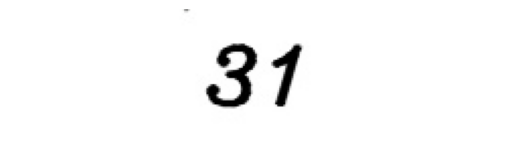

In [ ]:
img = cv2.imread('cards/card_2.jpg')
#Check region (30, 1012, 245, 120)
x, y, w, h = 60, 1040, 245, 65
crop = img[y:y+h, x:x+w]
plt.imshow(crop)
plt.axis('off')
plt.show()